# Simulation of Sequences

In [1]:
import numpy as np
from pulser import Pulse, Sequence, Register, Simulation
from pulser.waveforms import BlackmanWaveform, RampWaveform
from pulser.devices import MockDevice

import qutip
import matplotlib.pyplot as plt

Let us first define a simple one-dimensional system with periodic boundary conditions:

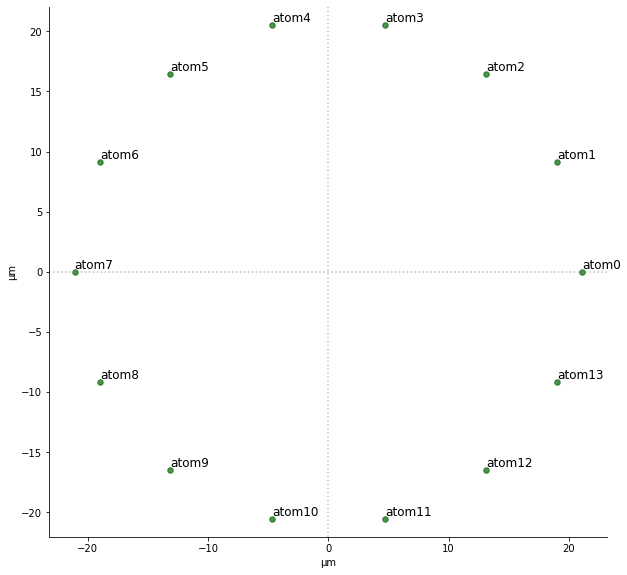

In [2]:
# Setup
L = 14

Omega_max = 2.3 * 2*np.pi 
U = Omega_max / 2.3

delta_0 = -3 * U
delta_f = 1 * U

t_rise = 2000
t_fall = 2000
t_sweep = (delta_f - delta_0)/(2 * np.pi * 10) * 5000

# Define a ring of atoms distanced by a blockade radius distance:
R_interatomic = MockDevice.rydberg_blockade_radius(U)
coords = R_interatomic/(2*np.tan(np.pi/L)) * np.array([(np.cos(theta*2*np.pi/L), np.sin(theta*2*np.pi/L)) for theta in range(L)])
                                  
reg = Register.from_coordinates(coords, prefix='atom')

reg.draw()

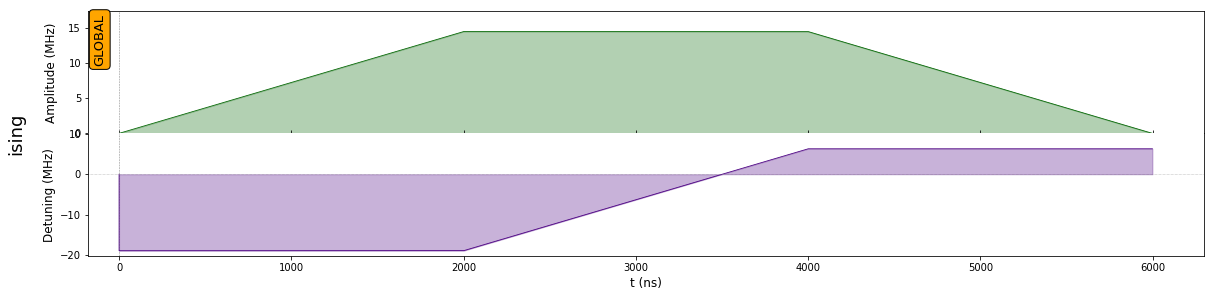

In [3]:
rise = Pulse.ConstantDetuning(RampWaveform(t_rise, 0., Omega_max), delta_0, 0.)
sweep = Pulse.ConstantAmplitude(Omega_max, RampWaveform(t_sweep, delta_0, delta_f), 0.)
fall = Pulse.ConstantDetuning(RampWaveform(t_fall, Omega_max, 0.), delta_f, 0.)

seq = Sequence(reg, MockDevice)
seq.declare_channel('ising', 'rydberg_global')

seq.add(rise, 'ising')
seq.add(sweep, 'ising')
seq.add(fall, 'ising')

seq.draw()

## Running a Simulation

First we define our `Simulation` object, which creates an internal respresentation of the quantum system, including the Hamiltonian which will drive the evolution:

In [4]:
sim = Simulation(seq, sampling_rate=0.02)

Notice we have included the parameter `sampling_rate` which allows us to determine how many samples from the pulse sequence we wish to simulate. In the case of the simple shapes in our sequence, only a very small fraction is needed. This largely accelerates the simulation time in the solver.

To run the simulation we simply apply the method `run()`. The method returns a `SimulationResults` object, which will allow the study or post-processing of the states for each time step in our simulation. Additionally, we can include a progress bar to have an estimate of how the simulation is advancing:

In [5]:
results = sim.run(progress_bar=True)

10.0%. Run time:   0.41s. Est. time left: 00:00:00:03
20.0%. Run time:   0.91s. Est. time left: 00:00:00:03
30.0%. Run time:   1.65s. Est. time left: 00:00:00:03
40.0%. Run time:   2.66s. Est. time left: 00:00:00:03
50.0%. Run time:   3.46s. Est. time left: 00:00:00:03
60.0%. Run time:   4.22s. Est. time left: 00:00:00:02
70.0%. Run time:   5.12s. Est. time left: 00:00:00:02
80.0%. Run time:   5.96s. Est. time left: 00:00:00:01
90.0%. Run time:   6.60s. Est. time left: 00:00:00:00
Total run time:   7.06s


## Using the `SimulationResults` object

The `SimulationResults` object that we created contains the quantum state at each time step. We can call them using the `states` attribute:

In [10]:
results.states[23] # Given as a `qutip.Qobj` object

Quantum object: dims = [[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], shape = (16384, 1), type = ket
Qobj data =
  (0, 0)	(-5.711808082984034e-06-2.1287517251206242e-06j)
  (1, 0)	(-7.213896490453041e-07-2.391671956233466e-07j)
  (2, 0)	(-7.213896490453067e-07-2.391671956233474e-07j)
  (3, 0)	(-1.0089744019566979e-07-3.0329146155870864e-08j)
  (4, 0)	(-7.213896490453026e-07-2.391671956233468e-07j)
  (5, 0)	(-8.989617576061196e-08-2.7721300878291143e-08j)
  (6, 0)	(-1.0089744019566984e-07-3.0329146155870804e-08j)
  (7, 0)	(-1.9461523538915626e-08+2.0908026006910278e-09j)
  (8, 0)	(-7.213896490453007e-07-2.3916719562334587e-07j)
  (9, 0)	(-8.973093668104949e-08-2.7671640110282676e-08j)
  (10, 0)	(-8.989617576061171e-08-2.7721300878291415e-08j)
  (11, 0)	(-1.8820859610054597e-08+3.3781878340861634e-09j)
  (12, 0)	(-1.0089744019566903e-07-3.032914615587079e-08j)
  (13, 0)	(-1.8820859610054885e-08+3.3781878340854198e-09j)
  (14, 0)	(-1.946152353891

We can sample the final state directly, using the `sample_final_state()` method from the `SimulationResults` object. We try it with $1000$ samples and discard the less frequent bitstrings:

<BarContainer object of 38 artists>

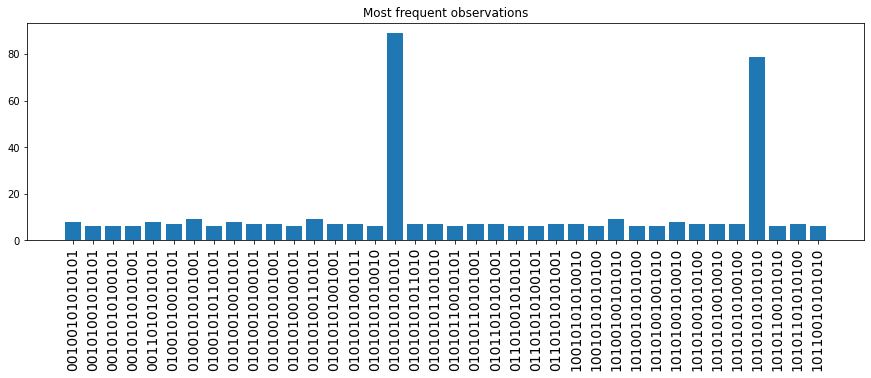

In [6]:
counts = results.sample_final_state(meas_basis='ground-rydberg', N_samples=1000)

large_counts = {k:v for k,v in counts.items() if v > 5}

plt.figure(figsize=(15,4))
plt.xticks(rotation=90, fontsize=14)
plt.title("Most frequent observations")
plt.bar(large_counts.keys(), large_counts.values())

Notice how the most frequent bitstrings correspond to the antiferromagnetic ordered states.

We can also compute the expectation values of operators for the states in the evolution, using the `expect()` method, which takes a list of operators (in this case, the local magnetization acting on the $j$-th spin):

In [7]:
def magnetization(j, total_sites):
    prod = [qutip.qeye(2) for _ in range(total_sites)]
    prod[j] = qutip.sigmaz()
    return qutip.tensor(prod)

magn_list = [magnetization(j, L) for j in range(L)]

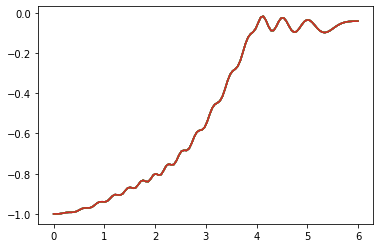

In [8]:
expect_magnetization = results.expect(magn_list)
for data in expect_magnetization:
    plt.plot(sim._times, data)

We can see how the local magnetization on *each* atom goes in the same way from $-1$ (which corresponds to the ground state) to $+1$ (which corresponds to the Rydberg level. This is natural since as we saw above, we are arriving at the antiferromagnetic ordered state $\Big(|grgr\cdots \rangle + |rgrg\cdots \rangle\Big)/\sqrt{2}$